In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import pyccl as ccl
import matplotlib.pylab as plt

# jax cosmo
from jax_cosmo.core import Cosmology
from jax_cosmo.power import linear_matter_power, nonlinear_matter_power
import jax_cosmo.power as jcp

# the emulator part
from jax_cosmo.power import linear_matter_power_emu

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 12

In [ ]:
cosmo_jax = Cosmology(Omega_c=0.25,
                      Omega_b=0.05,
                      h=0.7,
                      sigma8 = 0.8,
                      n_s=0.96,
                      Omega_k=0.,
                      w0=-1.,
                      wa=0.,
                     Neff = 3.044)

cosmo_ccl = ccl.Cosmology(Omega_c=0.25,
                          Omega_b=0.05,
                          h=0.7,
                          sigma8 = 0.8,
                          n_s=0.96,
                          Neff = 3.044,
                          transfer_function='eisenstein_hu',
                          matter_power_spectrum='halofit')

In [3]:
wavenumbers = jnp.geomspace(1E-4, 50, 500)
scalefactor = 1.0

In [ ]:
@jax.jit
def jax_linear_pk_emu(cosmology, wavenumbers, scalefactor):
    """
    JAXCOSMO outputs the power spectrum in a different unit. So we scale by h^3 for the power and h for the wavenumbers.
    """
    pk_jax = linear_matter_power_emu(cosmology, wavenumbers / cosmology.h, a=scalefactor) / cosmology.h**3
    return pk_jax


@jax.jit
def jax_linear_pk_eh(cosmology, wavenumbers, scalefactor):
    """
    JAXCOSMO outputs the power spectrum in a different unit. So we scale by h^3 for the power and h for the wavenumbers.
    """
    pk_jax = linear_matter_power(cosmology, wavenumbers / cosmology.h, a=scalefactor) / cosmology.h**3
    return pk_jax


In [5]:
jcp.USE_EMU = True
pk_jax_emu = jax_linear_pk_emu(cosmo_jax, wavenumbers, scalefactor)

jcp.USE_EMU = False
pk_jax_eh = jax_linear_pk_eh(cosmo_jax, wavenumbers, scalefactor)

## Linear Matter Power Spectrum


In [ ]:
# In CCL Wavenumber is in Mpc^-1 and returns the power spectrum in Mpc^3
pk_ccl = ccl.linear_matter_power(cosmo_ccl, wavenumbers, scalefactor)

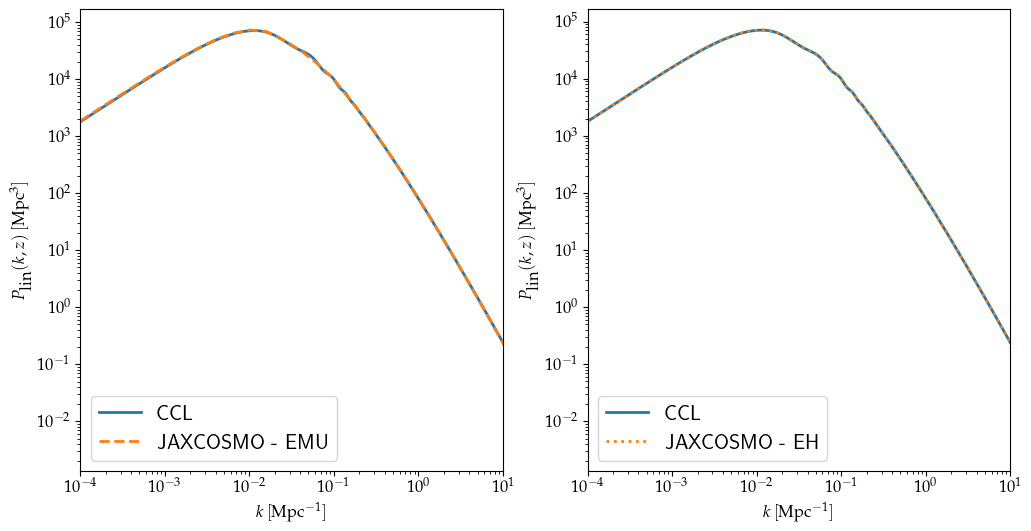

In [7]:
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.plot(wavenumbers, pk_ccl, lw = 2, label = 'CCL')
plt.plot(wavenumbers, pk_jax_emu, lw = 2, linestyle = '--', label = 'JAXCOSMO - EMU')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$P_{\textrm{lin}}(k,z)\,[\textrm{Mpc}^{3}]$', fontsize = fontSize)
plt.xlabel(r'$k\,[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(wavenumbers), 10)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})

plt.subplot(122)
plt.plot(wavenumbers, pk_ccl, lw = 2, label = 'CCL')
plt.plot(wavenumbers, pk_jax_eh, lw = 2, linestyle = ':', label = 'JAXCOSMO - EH')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$P_{\textrm{lin}}(k,z)\,[\textrm{Mpc}^{3}]$', fontsize = fontSize)
plt.xlabel(r'$k\,[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(wavenumbers), 10)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

## New Tracers

Implement a new Tracer and see how it compares with CCL.


In [8]:
from jax_cosmo.probes import CIBTracer

In [9]:
z_min = 0.0
z_max = 6.0
n_chi = 1024

## CIBTracer

$A=1$ and $\alpha = 1$


In [ ]:
ccl_tracer = ccl.CIBTracer(cosmo_ccl,
                           z_min = z_min,
                           z_max = z_max,
                           n_chi= n_chi)
w_ccl, chi_ccl = ccl_tracer.get_kernel()

jax_tracer = CIBTracer(z_min = z_min, z_max = z_max, n_z = n_chi)
w_jax, chi_jax = jax_tracer.kernel(cosmo_jax)

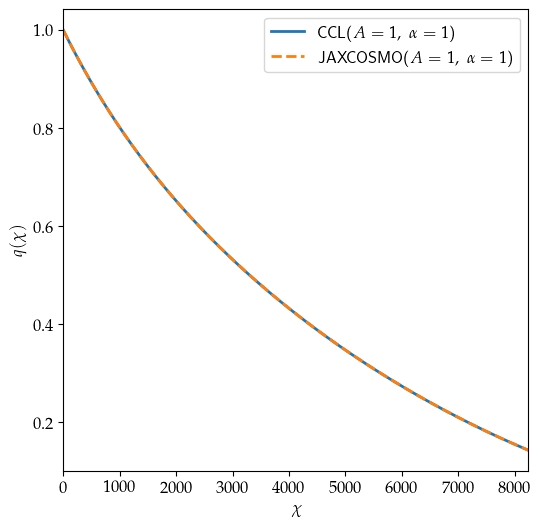

In [11]:
plt.figure(figsize = (6, 6))
plt.plot(chi_ccl[0], w_ccl[0], lw = 2, label = 'CCL' + r'($A=1,\;\alpha=1$)')
plt.plot(chi_jax / cosmo_jax.h, w_jax, lw = 2, linestyle = '--', label = 'JAXCOSMO' + r'($A=1,\;\alpha=1$)')
plt.ylabel(r'$q(\chi)$', fontsize = fontSize)
plt.xlabel(r'$\chi$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(chi_ccl[0]), max(chi_ccl[0]))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':12})
plt.show()

## Power From $z$

$A=1$ and $\alpha=2$


In [12]:
from jax_cosmo.probes import zPowerTracer

In [ ]:
ccl_tracer_power = ccl.tracers.Tracer.from_z_power(cosmo_ccl,
                           A = 1,
                           alpha = 2,
                           z_min = z_min,
                           z_max = z_max,
                           n_chi= n_chi)
w_ccl_power, chi_ccl_power = ccl_tracer_power.get_kernel()

In [14]:
jax_tracer_power = zPowerTracer(z_min = z_min, z_max = z_max, n_z = n_chi)
w_jax_power, chi_jax_power = jax_tracer_power.kernel(cosmo_jax, amplitude=1, alpha=2)

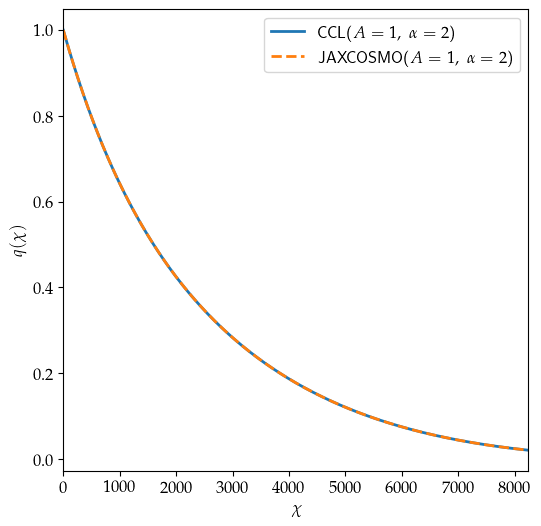

In [15]:
plt.figure(figsize = (6, 6))
plt.plot(chi_ccl_power[0], w_ccl_power[0], lw = 2, label = 'CCL'+ r'($A=1,\;\alpha=2$)')
plt.plot(chi_jax_power / cosmo_jax.h, w_jax_power, lw = 2, linestyle = '--', label = 'JAXCOSMO' + r'($A=1,\;\alpha=2$)')
plt.ylabel(r'$q(\chi)$', fontsize = fontSize)
plt.xlabel(r'$\chi$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(chi_ccl[0]), max(chi_ccl[0]))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':12})
plt.show()

## tSZTracer


In [16]:
from jax_cosmo.probes import tSZTracer

In [17]:
ccl_tSZ = ccl.tSZTracer(cosmo_ccl, z_max=z_max, n_chi=n_chi)
w_ccl_tSZ, chi_ccl_tSZ = ccl_tSZ.get_kernel()

In [18]:
jax_tracer_tSZ = tSZTracer(z_max = z_max, n_z = n_chi)
w_jax_tSZ, chi_jax_tSZ = jax_tracer_tSZ.kernel(cosmo_jax)

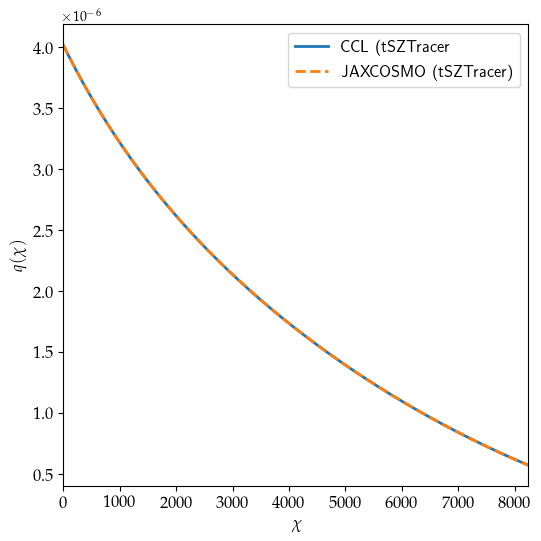

In [19]:
plt.figure(figsize = (6, 6))
plt.plot(chi_ccl_tSZ [0], w_ccl_tSZ[0], lw = 2, label = 'CCL (tSZTracer')
plt.plot(chi_jax_tSZ / cosmo_jax.h, w_jax_tSZ, lw = 2, linestyle = '--', label = 'JAXCOSMO (tSZTracer)')
plt.ylabel(r'$q(\chi)$', fontsize = fontSize)
plt.xlabel(r'$\chi$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(chi_ccl[0]), max(chi_ccl[0]))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':12})
plt.show()

## ISWTracer


In [20]:
from jax.tree_util import register_pytree_node_class
from jax_cosmo.jax_utils import container
import jax_cosmo.background as bkgrd
import jax_cosmo.cclconstants as cst

In [ ]:
def isw_kernel(cosmo, z_max: float, n_z: int) -> np.ndarray:
    a_arr, chi = bkgrd.scale_of_chi(cosmo, 0.0, z_max, n_z)
    H0 = cosmo.h / cst.CLIGHT_HMPC
    OM = cosmo.Omega_m
    Ez = bkgrd.H(cosmo, a_arr) / 100

    # this is a hack to get this working - need to understand the growth rate.
    fz = bkgrd.growth_rate(cosmo, a_arr)
    # fz = cosmo_ccl.growth_rate(a_arr)
    w_arr = 3 * cst.T_CMB * H0**3 * OM * Ez * chi**2 * (1-fz)
    return w_arr, chi

@register_pytree_node_class
class ISWTracer(container):
    """Class representing the Tracer associated with the integrated Sachs-Wolfe effect (ISW)

    z_max (float, optional): The maximim redshift. Defaults to 6.0.
    n_z (int, optional): The number of redshifts. Defaults to 1024.
    """

    def __init__(self, z_max=6.0, n_z=1024):
        super(ISWTracer, self).__init__(z_max, n_z)

    @property
    def zmax(self) -> float:
        """Returns the maximum redsfhit probed by this probe

        Returns:
            float: maximum redshift
        """
        return self.params[0]

    @property
    def n_z(self) -> int:
        """Returns the number of redshifts

        Returns:
            int: number of redshifts
        """
        return self.params[1]

    def kernel(self, cosmo: Cosmology) -> np.ndarray:
        """Calculates the cosmic infrared background kernel.

        Args:
            cosmo (Cosmology): the cosmology object in JAX COSMO

        Returns:
            np.ndarray: the ISW kernel.
        """
        inputs = {
            "z_max": self.params[0],
            "n_z": self.params[1],
        }
        return isw_kernel(cosmo, **inputs)

In [22]:
z_max = 6
n_z = 1000

In [23]:
jax_tracer_ISW = ISWTracer(z_max = z_max, n_z = n_chi)
w_jax_ISW, chi_jax_ISW = jax_tracer_ISW.kernel(cosmo_jax)

In [24]:
ccl_ISW_Tracer = ccl.ISWTracer(cosmo_ccl, z_max=z_max, n_chi=n_chi)
w_ccl_ISW, chi_ccl_ISW = ccl_ISW_Tracer.get_kernel()

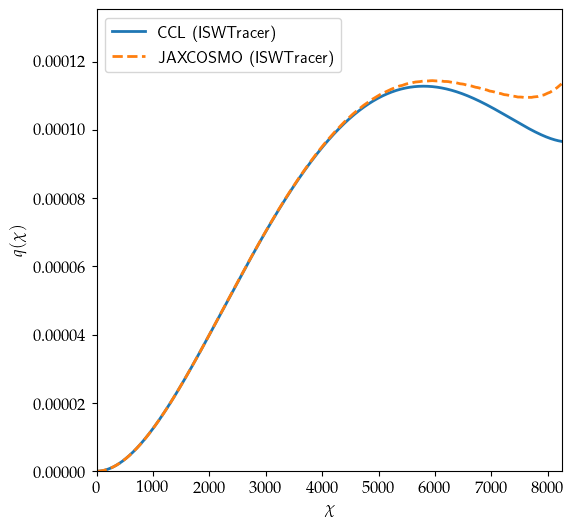

In [25]:
plt.figure(figsize = (6, 6))
plt.plot(chi_ccl_ISW[0], w_ccl_ISW[0], lw = 2, label = 'CCL (ISWTracer)')
plt.plot(chi_jax_ISW / cosmo_jax.h, w_jax_ISW / cosmo_jax.h**2 , lw = 2, linestyle = '--', label = 'JAXCOSMO (ISWTracer)')
plt.ylabel(r'$q(\chi)$', fontsize = fontSize)
plt.xlabel(r'$\chi$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(chi_ccl_ISW[0]), max(chi_ccl_ISW[0]))
plt.ylim(0.0,  1.2*max([max(w_ccl_ISW[0]), max(w_jax_ISW)]))
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':12})
plt.show()

## CMB Lensing Kernel

<!-- <center>
    <img src="reference/cmb_lensing.png" alt="Image" style="width: 50%; height: auto;" />
</center>
 -->


In [26]:
from jax_cosmo.probes import CMBLensingTracer
from typing import Tuple
from jax_cosmo.core import Cosmology
import jax_cosmo.constants as const
from jax_cosmo.utils import z2a

In [27]:
z_source = 1100
n_samples = 100

In [28]:
jax_tracer_CMB = CMBLensingTracer(z_source = z_source, n_samples=n_samples)
w_jax_CMB, chi_jax_CMB = jax_tracer_CMB.kernel(cosmo_jax)

In [29]:
ccl_CMB_Tracer = ccl.CMBLensingTracer(cosmo_ccl, z_source=z_source, n_samples=n_samples)
w_ccl_CMB, chi_ccl_CMB = ccl_CMB_Tracer.get_kernel()

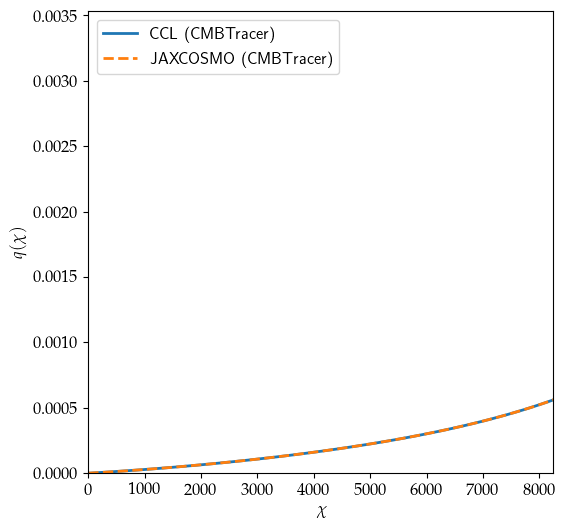

In [30]:
plt.figure(figsize = (6, 6))
plt.plot(chi_ccl_CMB[0], w_ccl_CMB[0], lw = 2, label = 'CCL (CMBTracer)')
plt.plot(chi_jax_CMB / cosmo_jax.h, w_jax_CMB / cosmo_jax.h, lw = 2, linestyle = '--', label = 'JAXCOSMO (CMBTracer)')
plt.ylabel(r'$q(\chi)$', fontsize = fontSize)
plt.xlabel(r'$\chi$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(chi_ccl_ISW[0]), max(chi_ccl_ISW[0]))
plt.ylim(0.0, 1.2*max(w_ccl_CMB[0]))
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':12})
plt.show()

### Distance Calculation

We have included the radiation term.


In [31]:
z_source = 1000
a_source = 1. / (1. + z_source)

In [32]:
ccl.background.comoving_radial_distance(cosmo_ccl, a = a_source)

13622.366045805722

In [33]:
bkgrd.radial_comoving_distance(cosmo_jax, a = a_source).item() / cosmo_jax.h

13622.396328179484

### Scalefactor of $\chi$


In [34]:
a_arr_jax, chi_arr_jax = bkgrd.scale_of_chi(cosmo_jax, 0.0, z_source, 500)

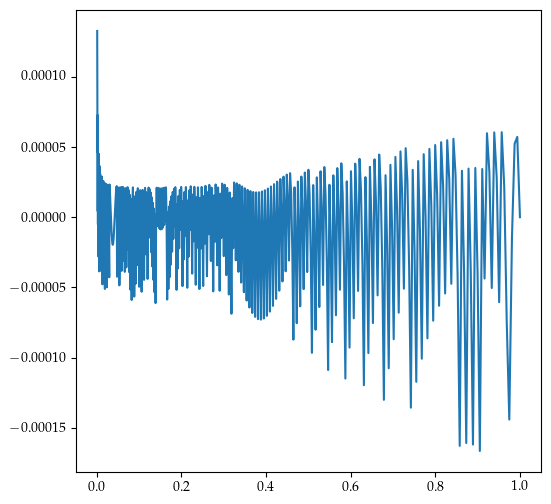

In [35]:
plt.figure(figsize = (6,6))
plt.plot(a_arr_jax, a_arr_jax / ccl.scale_factor_of_chi(cosmo_ccl, chi_arr_jax / cosmo_jax.h) - 1.0)
plt.show()

In [ ]:
z_min = 0
z_max = 1100
n_z = 50

a_min = z2a(z_min)
a_max = z2a(z_max)
chi_min = bkgrd.radial_comoving_distance(cosmo_jax, a=a_min)[0]
chi_max = bkgrd.radial_comoving_distance(cosmo_jax, a=a_max)[0]

redshifts = np.linspace(z_min, z_max, n_z)
scalefactors = z2a(redshifts)
chi_grid = bkgrd.radial_comoving_distance(cosmo_jax, scalefactors) / cosmo_jax.h

# we want the equivalent a_arr
chi_arr = np.linspace(chi_min, chi_max, n_z)

# jc implementation
a_arr_jax = bkgrd.a_of_chi(cosmo_jax, chi_arr )

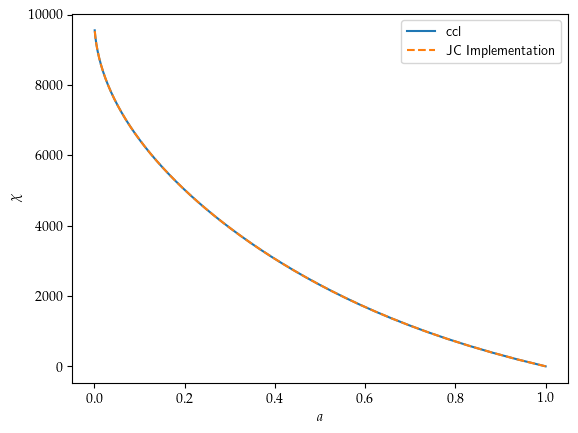

In [37]:
plt.plot(ccl.scale_factor_of_chi(cosmo_ccl, chi_arr / cosmo_jax.h), chi_arr, label = 'ccl')
plt.plot(a_arr_jax, chi_arr, linestyle = '--', label = 'JC Implementation')
plt.legend()
plt.ylabel(r'$\chi$')
plt.xlabel(r'$a$')
plt.show()

### Comoving Radial Distance


In [38]:
z_grid = np.linspace(0, 1100, 1000)
a_grid = 1. / (1 + z_grid)
ccl_dist = ccl.background.comoving_radial_distance(cosmo_ccl, a = a_grid)
jax_dist = bkgrd.radial_comoving_distance(cosmo_jax, a = a_grid) / cosmo_jax.h

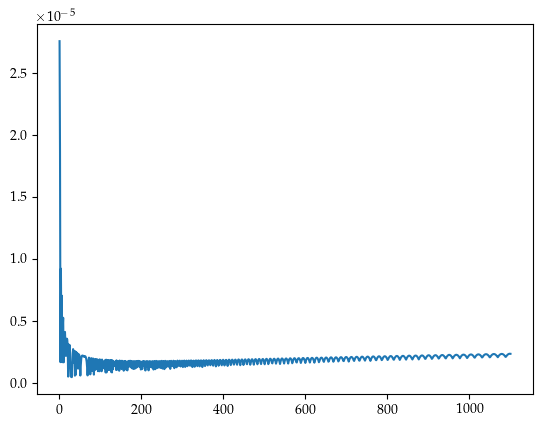

In [39]:
plt.plot(z_grid, jax_dist/ccl_dist - 1.0)
plt.show()

# Growth Rate and Growth Factor

The following is calculated directly from the JAX Cosmo implementation.


### Implementation of Differential Equations


In [3]:
from jax_cosmo.background import H, Omega_m_a
import jax_cosmo.background as bkgrd
from jax_cosmo.utils import a2z
from jax import grad

In [ ]:
def grad_H(cosmo, a):
    return grad(H, argnums=1)(cosmo, a)

def alpha_beta(cosmo, a):
    gH_over_H = grad_H(cosmo, a) / H(cosmo, a)
    alpha = 5. / a + gH_over_H
    beta = 3/a**2 + gH_over_H/a - 1.5 * Omega_m_a(cosmo, a)/a**2
    return jnp.array([[0.0, 1.0], [-beta, -alpha]])

def cash_karp_method(func, y0, t):

    def cash_karp(carry, t):
        y, t_prev = carry
        h = t - t_prev
        k1 = func(y, t_prev)
        k2 = func(y + h * k1 / 5, t_prev + 0.2*h)
        k3 = func(y + h * (3 * k1 / 40 +  9 * k2 / 40), t_prev + 0.3*h)
        k4 = func(y + h * (3 * k1 / 10 - 9 * k2 / 10 + 6 * k3 / 5), t_prev + 0.6*h)
        k5 = func(y + h * (-11 * k1 / 54 + 5 * k2 / 2 - 70 * k3 / 27 + 35 * k4 / 27), t_prev + h)
        k6 = func(y + h * (1631 * k1 / 55296 + 175 * k2 / 512 + 575 * k3 / 13824 + 44275 * k4 / 110592 + 253 * k5 / 4096), t_prev + 0.875*h)
        y = y + h * (37*k1/378 + 250*k3/621 + 125*k4/594 + 512*k6/1771)
        return (y, t), y
    (yf, _), y = jax.lax.scan(cash_karp, (y0, np.array(t[0])), t)
    return y

def euler_method(func, y0, t):

    def euler(carry, t):
        y, t_prev = carry
        h = t - t_prev
        k1 = func(y, t_prev)
        y = y + h * k1
        return (y, t), y

    (yf, _), y = jax.lax.scan(euler, (y0, np.array(t[0])), t)
    return y

In [ ]:
def growth_factor_calculation(cosmo, log10_amin=-3.1, steps=512, method = 'euler'):

    atab = np.logspace(log10_amin, 0.0, steps)
    y0 = np.array([1.0, atab[0]])

    def g_derivs(y, x):
        return alpha_beta(cosmo, x) @ y

    if method == 'euler':
        y_record = euler_method(g_derivs, y0, atab)
    elif method == 'cash-karp':
        y_record = cash_karp_method(g_derivs, y0, atab)

    # calculate growth rate
    growth_rate = (atab * y_record[:,1] / y_record[:,0]) + 1.0

    # calculate growth factor
    growth_factor = atab * y_record[:,0]
    growth_factor /= growth_factor[-1]

    return atab, growth_rate, growth_factor

In [13]:
A_MIN = -3.1
STEPS = 512

print(f"Maximum redshift is {a2z(10**A_MIN):.2f}")

Maximum redshift is 1257.93


In [ ]:
atab, gr_euler, gf_euler = growth_factor_calculation(cosmo_jax, log10_amin=A_MIN, steps=STEPS, method = 'euler')
atab, gr_ck, gf_ck = growth_factor_calculation(cosmo_jax, log10_amin=A_MIN, steps=STEPS, method = 'cash-karp')
gr_jax = bkgrd.growth_rate(cosmo_jax, atab)
gr_ccl = cosmo_ccl.growth_rate(atab)

gf_jax = bkgrd.growth_factor(cosmo_jax, atab)
gf_ccl = cosmo_ccl.growth_factor(atab)

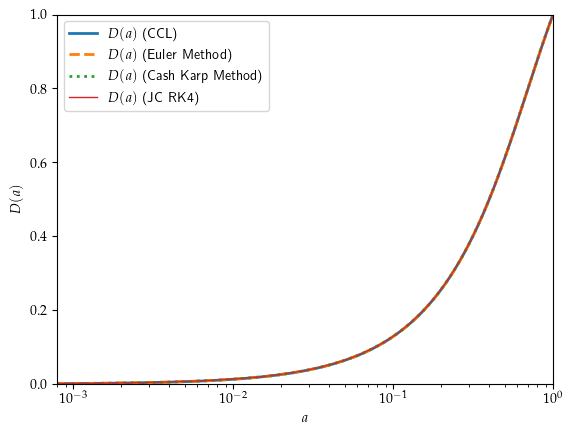

In [15]:
plt.plot(atab, gf_ccl, lw = 2, label = r'$D(a)$ (CCL)')
plt.plot(atab, gf_euler, lw = 2, linestyle = '--', label = r'$D(a)$ (Euler Method)')
plt.plot(atab, gf_ck, lw = 2, linestyle = ':', label = r'$D(a)$ (Cash Karp Method)')
plt.plot(atab, gf_jax, lw = 1, label = r'$D(a)$ (JC RK4)')
plt.xlabel(r'$a$')
plt.ylabel(r'$D(a)$')
plt.xscale('log')
plt.ylim(0, 1.0)
plt.xlim(min(atab), max(atab))
plt.legend()
plt.show()

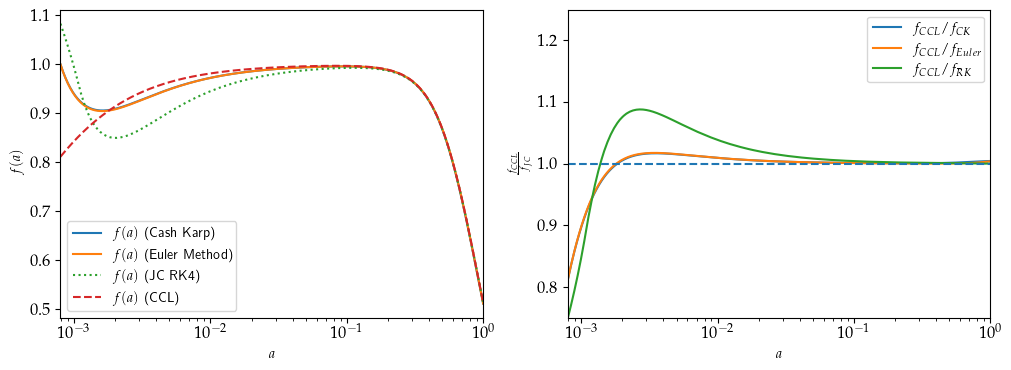

In [16]:
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.plot(atab, gr_ck, label = '$f(a)$ (Cash Karp)')
plt.plot(atab, gr_euler, label = '$f(a)$ (Euler Method)')
plt.plot(atab, gr_jax, linestyle = ':', label = '$f(a)$ (JC RK4)')
plt.plot(atab, gr_ccl, linestyle = '--', label = '$f(a)$ (CCL)')
plt.xlabel(r'$a$')
plt.ylabel(r'$f(a)$')
plt.xscale('log')
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(atab), max(atab))
plt.legend()
plt.subplot(122)
plt.plot(atab, gr_ccl / gr_ck, label = '$f_{CCL}/f_{CK}$')
plt.plot(atab, gr_ccl / gr_euler, label = '$f_{CCL}/f_{Euler}$')
plt.plot(atab, gr_ccl / gr_jax, label = '$f_{CCL}/f_{RK}$')
plt.axhline(1, linestyle = '--')
plt.ylim(0.75, 1.25)
plt.xlabel(r'$a$')
plt.xscale('log')
plt.ylabel(r'$\frac{f_{CCL}}{f_{JC}}$')
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(atab), max(atab))
plt.legend()
plt.show()

# Transfer Function

In [10]:
from jax_cosmo.transfer import BBKS, Eisenstein_Hu
from jax_cosmo.power import linear_matter_power

In [11]:
kvalues = np.logspace(-4, 1, 100)

In [12]:
pklin_bbks = linear_matter_power(cosmo_jax, kvalues / cosmo_jax.h, a = 1.0, transfer_fn=BBKS) / cosmo_jax.h**3

cosmo_ccl_bbks = ccl.Cosmology(Omega_c=0.25,
                          Omega_b=0.05,
                          h=0.7,
                          sigma8 = 0.8,
                          n_s=0.96,
                          Neff = 3.044,
                          transfer_function='bbks')

pklin_ccl_bbks = cosmo_ccl_bbks.linear_matter_power(kvalues, a = 1.0)

In [13]:
pklin_eh = linear_matter_power(cosmo_jax,  kvalues / cosmo_jax.h, a = 1.0, transfer_fn=Eisenstein_Hu) / cosmo_jax.h**3

cosmo_ccl_eh = ccl.Cosmology(Omega_c=0.25,
                          Omega_b=0.05,
                          h=0.7,
                          sigma8 = 0.8,
                          n_s=0.96,
                          Neff = 3.044,
                          transfer_function='eisenstein_hu')

pklin_ccl_eh = cosmo_ccl_eh.linear_matter_power(kvalues, a = 1.0)

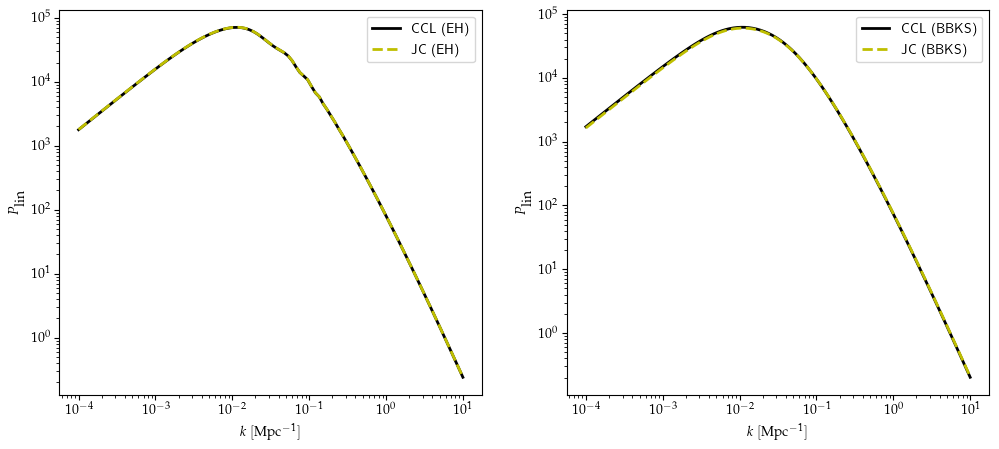

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(kvalues, pklin_ccl_eh, c = 'k', lw=2, label = 'CCL (EH)')
plt.plot(kvalues, pklin_eh , c = 'y', linestyle = '--', lw = 2, label = 'JC (EH)')
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$')
plt.ylabel(r'$P_{\textrm{lin}}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')

plt.subplot(122)
plt.plot(kvalues, pklin_ccl_bbks, c = 'k', lw=2, label = 'CCL (BBKS)')
plt.plot(kvalues, pklin_bbks, c = 'y', lw=2, linestyle = '--', label = 'JC (BBKS)')
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$')
plt.ylabel(r'$P_{\textrm{lin}}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

## Halo Model

In [6]:
from typing import Union, Callable, Tuple
from jax import jit
from jax_cosmo.background import Omega_m_a, Esqr
from interpax import Interpolator1D
from dataclasses import dataclass
from typing import Optional
from jax_cosmo.power import sigmasqr
import jax_cosmo.transfer as tklib
import jax.numpy as jnp
from typing import Union
from interpax import Interpolator2D
from jax import vmap
from quadax import quadgk, simpson
from functools import partial
import pyccl.halos as halos
from jax_cosmo.utils import z2a

jcp.USE_EMU = True

In [257]:
# Define species labels as enums or constants
SPECIES_CRIT = "crit"
SPECIES_M = "matter"

# Precision parameters
GSL_EPSREL = 1E-4  # Default relative precision
GSL_N_ITERATION = 1000  # Default number of iterations for integration and root-finding
GSL_INTEGRATION_GAUSS_KRONROD_POINTS = 41  # Default number of Gauss-Kronrod points in QAG integration
GSL_EPSREL_SIGMAR = 1E-5  # Relative precision in sigma_R calculations
GSL_EPSREL_KNL = 1E-5  # Relative precision in k_NL calculations
GSL_EPSREL_DIST = 1E-6  # Relative precision in distance calculations
GSL_EPSREL_GROWTH = 1E-6  # Relative precision in growth calculations
GSL_EPSREL_DNDZ = 1E-6  # Relative precision in dNdz calculations

@dataclass
class PhysicalConstants:
    """Defines physical constants based on CODATA 2022 and other sources."""

    SIDEREAL_YEAR_SEC: float = 365.256363004 * 86400.0  # Seconds in a sidereal year
    LIGHT_SPEED_H0_MPC: float = 2997.92458  # c/H0 in Mpc/h
    GRAVITATIONAL_CONSTANT: float = 6.67430e-11  # m^3/kg/s^2
    SOLAR_MASS_KG: float = 1.988409871e30  # kg
    MPC_TO_METERS: float = 3.085677581491367399198952281e22  # Mpc to meters
    RHO_CRITICAL: float = (3 * 100**2) / (8 * jnp.pi * GRAVITATIONAL_CONSTANT) * \
                   ((1000 * 1000 * MPC_TO_METERS) / SOLAR_MASS_KG)
    BOLTZMANN_CONSTANT: float = 1.380649e-23  # J/K
    STEFAN_BOLTZMANN_CONSTANT: float = 5.670374419e-8  # kg/s^3/K^4
    PLANCK_CONSTANT: float = 6.62607015e-34  # kg m^2 / s
    LIGHT_SPEED: float = 299792458.0  # m/s
    ELECTRON_VOLT_TO_JOULE: float = 1.602176634e-19  # eV to Joules
    NEUTRINO_SPLITTING_1: float = 7.62e-5
    NEUTRINO_SPLITTING_2: float = 2.55e-3
    NEUTRINO_SPLITTING_3: float = -2.43e-3
    T_CMB: float = 2.7255  # K
    T_NCDM: float = 0.71611  # K

@dataclass
class CCLSplineParams:
    # Scale factor spline parameters
    A_SPLINE_NA: int = 250
    A_SPLINE_MIN: float = 0.1
    A_SPLINE_MINLOG_PK: float = 0.01
    A_SPLINE_MIN_PK: float = 0.1
    A_SPLINE_MINLOG_SM: float = 0.01
    A_SPLINE_MIN_SM: float = 0.1
    A_SPLINE_MAX: float = 1.0
    A_SPLINE_MINLOG: float = 0.0001
    A_SPLINE_NLOG: int = 250

    # Mass splines
    LOGM_SPLINE_DELTA: float = 0.025
    LOGM_SPLINE_NM: int = 50
    LOGM_SPLINE_MIN: int = 6
    LOGM_SPLINE_MAX: int = 17

    # Power spectrum a and k splines
    A_SPLINE_NA_SM: int = 13
    A_SPLINE_NLOG_SM: int = 6
    A_SPLINE_NA_PK: int = 40
    A_SPLINE_NLOG_PK: int = 11

    # k-splines and integrals
    K_MAX_SPLINE: int = 50
    K_MAX: float = 1E3
    K_MIN: float = 5E-5
    DLOGK_INTEGRATION: float = 0.025
    DCHI_INTEGRATION: float = 5.0
    N_K: int = 167
    N_K_3DCOR: int = 100000

    # Correlation function parameters
    ELL_MIN_CORR: float = 0.01
    ELL_MAX_CORR: int = 60000
    N_ELL_CORR: int = 5000

    # Spline types (placeholders for now)
    spline1: Optional[None] = None
    spline2: Optional[None] = None
    spline3: Optional[None] = None
    spline4: Optional[None] = None
    spline5: Optional[None] = None
    spline6: Optional[None] = None
    spline7: Optional[None] = None

@dataclass
class CCLGSLParams:
    N_ITERATION: int = GSL_N_ITERATION
    INTEGRATION_GAUSS_KRONROD_POINTS: int = GSL_INTEGRATION_GAUSS_KRONROD_POINTS
    INTEGRATION_EPSREL: float = GSL_EPSREL
    INTEGRATION_LIMBER_GAUSS_KRONROD_POINTS: int = GSL_INTEGRATION_GAUSS_KRONROD_POINTS
    INTEGRATION_LIMBER_EPSREL: float = GSL_EPSREL
    INTEGRATION_DISTANCE_EPSREL: float = GSL_EPSREL_DIST
    INTEGRATION_SIGMAR_EPSREL: float = GSL_EPSREL_SIGMAR
    INTEGRATION_KNL_EPSREL: float = GSL_EPSREL_KNL
    ROOT_EPSREL: float = GSL_EPSREL
    ROOT_N_ITERATION: int = GSL_N_ITERATION
    ODE_GROWTH_EPSREL: float = GSL_EPSREL_GROWTH
    EPS_SCALEFAC_GROWTH: float = 1E-6
    NZ_NORM_SPLINE_INTEGRATION: bool = True
    LENSING_KERNEL_SPLINE_INTEGRATION: bool = True

# Create an instance of the default parameters
ccl_user_spline_params = CCLSplineParams()
ccl_user_gsl_params = CCLGSLParams()
ccl_constants = PhysicalConstants()

In [258]:
def omega_x(cosmo, a, label):
    """Computes the density parameter Omega_x at a given scale factor for a specified species.

    This function calculates the fractional energy density (Ω_x) of a cosmological component
    at a given scale factor `a`, normalized by the critical density.

    Args:
        cosmo: An object containing cosmological parameters (e.g., Omega_c, Omega_b).
        a (float): The scale factor at which to evaluate the density parameter.
        label (str): The species label (e.g., "matter", "lambda", "radiation").

    Returns:
        float: The density parameter Ω_x(a) for the specified species.

    """
    # Compute the Hubble normalization factor
    hnorm = jnp.sqrt(Esqr(cosmo, a))

    # Handle different cosmological species
    if label == SPECIES_CRIT:
        return 1.0

    elif label == SPECIES_M:
        quantity_1 = (cosmo.Omega_c + cosmo.Omega_b) / (a**3 * hnorm**2)
        quantity_2 = 0.0  # Placeholder for potential neutrino contribution
        return quantity_1 + quantity_2

def rho_x(cosmo: Cosmology, a: Union[float, np.ndarray], label: str) -> Union[float, np.ndarray]:
    """Computes the physical density of a given component in the universe.

    This function calculates the density of a specified cosmological component
    (e.g., matter, dark energy, radiation) at a given scale factor.

    Args:
        cosmo (Cosmology): The cosmological model containing parameters such as Hubble constant.
        a (Union[float, np.ndarray]): The scale factor at which the density is computed.
        label (str): The label identifying the cosmological component (e.g., 'matter', 'radiation').

    Returns:
        Union[float, np.ndarray]: The density of the specified component in units of
        critical density times Omega_x.
    """
    hnorm = jnp.sqrt(Esqr(cosmo, a))
    rhocrit = ccl_constants.RHO_CRITICAL * cosmo.h**2 * hnorm**2
    return omega_x(cosmo, a, label) * rhocrit



def mass2radius_lagrangian(cosmo: Cosmology, mass: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """Computes the Lagrangian radius for a given halo mass.

    The Lagrangian radius is defined as the radius that encloses the given halo mass
    under the assumption of a homogeneous Universe.

    Args:
        cosmo (Cosmology): An object containing cosmological parameters.
        mass (Union[float, np.ndarray]): The mass of the halo in solar masses.

    Returns:
        Union[float, np.ndarray]: The corresponding Lagrangian radius in the same shape as `mass`.
    """
    mass_use = jnp.atleast_1d(mass)
    rho_matter = rho_x(cosmo, 1.0, 'matter')  # Density of matter at a = 1
    radius_cube = mass_use / (4.0 / 3.0 * jnp.pi * rho_matter)
    radius = jnp.cbrt(radius_cube)  # Cube root to get radius

    return radius[0] if np.ndim(mass) == 0 else radius

In [259]:
class MassDefinition:
    def __init__(self, overdensity: Union[float, str] = 200, density_type: str = "matter"):
        self.overdensity = overdensity
        self.density_type = density_type

    def compute_virial_overdensity(self, cosmo, scale_factor: float) -> float:
        """Computes the virial collapse overdensity contrast relative to the critical density
        in a ΛCDM model using the Bryan & Norman (1998) fitting function.

        Args:
            cosmo: A Cosmology object.
            scale_factor: The cosmic scale factor.

        Returns:
            The virial overdensity relative to the specified density type.
        """
        omega_matter = omega_x(cosmo, scale_factor, "matter")
        omega_deviation = omega_matter - 1
        virial_overdensity = (18 * jnp.pi**2 + 82 * omega_deviation - 39 * omega_deviation**2)
        return (
            virial_overdensity / omega_matter
            if self.density_type == "matter"
            else virial_overdensity
        )

    def get_overdensity(self, cosmo, scale_factor: float) -> float:
        """Retrieves the overdensity parameter associated with this mass definition.

        Args:
            cosmo: A Cosmology object.
            scale_factor: The cosmic scale factor.

        Returns:
            The overdensity parameter.
        """
        if self.overdensity == "fof":
            raise ValueError(
                "FoF masses do not have a defined overdensity and cannot be converted."
            )
        return (
            self.compute_virial_overdensity(cosmo, scale_factor)
            if self.overdensity == "vir"
            else self.overdensity
        )

    def convert_to_matter_overdensity(self, cosmo, scale_factor: float) -> float:
        """Converts the overdensity parameter to be relative to the matter density.

        Args:
            cosmo: A Cosmology object.
            scale_factor: The cosmic scale factor.

        Returns:
            The equivalent overdensity parameter relative to matter.
        """
        overdensity_value = self.get_overdensity(cosmo, scale_factor)
        if self.density_type == "matter":
            return overdensity_value
        omega_target = omega_x(cosmo, scale_factor, self.density_type)
        omega_matter = omega_x(cosmo, scale_factor, "matter")
        return overdensity_value * omega_target / omega_matter


def get_delta_c(cosmo: Cosmology, scale_factor: float, method: str = "EdS") -> Union[float, np.ndarray]:
    """
    Computes the linear collapse threshold, which represents the density contrast
    required for a region to collapse under self-gravity.

    Args:
        cosmo (Cosmology): A cosmology object providing the background cosmology.
        scale_factor (float): The scale factor of the universe.
        method (str, optional): The prescription used to compute the linear collapse threshold. Options include:
            - "EdS": Standard spherical collapse prediction in an Einstein-de Sitter universe.
              Uses the formula: δ_c = (3/20) * (12π)^(2/3) ≈ 1.68647.
            - "EdS_approx": A common approximation to the EdS result, δ_c = 1.686.
            - "NakamuraSuto97": Uses the prescription from
              [Nakamura & Suto (1997)](https://arxiv.org/abs/astro-ph/9612074).
            - "Mead16": Uses the prescription from
              [Mead et al. (2016)](https://arxiv.org/abs/1602.02154).

    Returns:
        Union[float, np.ndarray]: The computed linear collapse threshold δ_c.

    Raises:
        ValueError: If an unknown method is provided.
    """
    # Standard collapse threshold in an Einstein-de Sitter (EdS) universe
    delta_c_eds = 1.68647019984

    if method == "EdS":
        return delta_c_eds
    elif method == "EdS_approx":
        return 1.686
    elif method == "NakamuraSuto97":
        omega_matter = omega_x(cosmo, scale_factor, "matter")
        return delta_c_eds * (1 + 0.012299 * np.log10(omega_matter))
    elif method == "Mead16":
        omega_matter = omega_x(cosmo, scale_factor, "matter")
        sigma_8_scaled = cosmo.sigma8 * cosmo.growth_factor(scale_factor)
        correction_sigma8 = (1.59 + 0.0314 * np.log(sigma_8_scaled))
        correction_omega = (1 + 0.0123 * np.log10(omega_matter))
        return correction_sigma8 * correction_omega
    else:
        raise ValueError(f"Unknown collapse threshold method: {method}")

In [260]:
def generate_massfunc_name(delta: int, density_type: str) -> str:
    """Generates a standardized name for a mass function based on the overdensity and density type.

    Args:
        delta (int): The overdensity value.
        density_type (str): The type of density (e.g., "matter").

    Returns:
        str: The standardized mass function name.
    """
    return f"{delta}{density_type[0]}"


class JAXMassFuncAngulo12:
    """
    Implements the Angulo et al. (2012) mass function model for halo abundance.

    This model describes the halo mass function using a fitting function
    based on cosmological simulations.

    Attributes:
        normalization_factor (float): Normalization constant for the mass function.
        shape_parameter (float): Shape parameter controlling the dependence on σ(M).
        power_law_exponent (float): Exponent of the power-law term in the function.
        exponential_cutoff (float): Parameter controlling the exponential suppression.
    """
    name: str = "Angulo12"

    def __init__(self, overdensity: Union[float, str] = "fof", density_type: str = "matter"):
        """
        Initializes the mass function with default parameters from Angulo et al. (2012).

        Args:
            overdensity (Union[float, str], optional): Overdensity parameter. Defaults to "fof".
            density_type (str, optional): Type of density (e.g., "matter"). Defaults to "matter".
        """
        self.normalization_factor = 0.201
        self.shape_parameter = 2.08
        self.power_law_exponent = 1.7
        self.exponential_cutoff = 1.172

    def compute_fsigma(self, cosmo: Cosmology, sigma_mass: float, scale_factor: float, log_mass: float) -> float:
        """
        Computes the halo mass function f(σ) based on the Angulo12 model.

        Args:
            cosmo (Cosmology): Cosmology object containing necessary parameters.
            sigma_mass (float): Standard deviation of the linear density field at mass scale M.
            scale_factor (float): Scale factor of the universe (a = 1 / (1+z)).
            log_mass (float): Logarithm of the halo mass.

        Returns:
            float: The value of f(σ), the mass function.
        """
        return (
            self.normalization_factor
            * ((self.shape_parameter / sigma_mass) ** self.power_law_exponent + 1.0)
            * jnp.exp(-self.exponential_cutoff / sigma_mass**2)
        )


class JAXMassFuncBocquet16:
    """
    Implements the mass function of Bocquet et al. (2016).

    This parametrization supports spherical overdensity (S.O.) masses defined with respect to:
    - Δ = 200, measured against the total matter density.
    - Δ = 200, measured against the critical density.
    - Δ = 500, measured against the critical density.

    Attributes:
        overdensity (Union[float, str]): Overdensity value (e.g., 200 or "500c").
        density_type (str): Type of density reference ("matter" or "critical").
        includes_hydro_effects (bool): Whether to include hydrodynamical effects.
        mass_def_name (str): Standardized mass function name.
        params (dict): Precomputed mass function parameters.
    """
    name: str = "Bocquet16"

    def __init__(self, overdensity: Union[float, str] = 200,
                 density_type: str = "matter",
                 includes_hydro_effects: bool = True):
        """
        Initializes the Bocquet16 mass function model with appropriate parameters.

        Args:
            overdensity (Union[float, str], optional): Overdensity value (e.g., 200 or "500c"). Defaults to 200.
            density_type (str, optional): Reference density type ("matter" or "critical"). Defaults to "matter".
            includes_hydro_effects (bool, optional): Whether to include hydrodynamical effects. Defaults to True.
        """
        self.overdensity = overdensity
        self.density_type = density_type
        self.includes_hydro_effects = includes_hydro_effects
        self.mass_def_name = generate_massfunc_name(self.overdensity, self.density_type)

        # Mass function parameters (based on Bocquet et al. 2016)
        mass_function_params = {
            (True, "200m"): (0.228, 2.15, 1.69, 1.30, 0.285, -0.058, -0.366, -0.045),
            (False, "200m"): (0.175, 1.53, 2.55, 1.19, -0.012, -0.040, -0.194, -0.021),
            (True, "200c"): (0.202, 2.21, 2.00, 1.57, 1.147, 0.375, -1.074, -0.196),
            (False, "200c"): (0.222, 1.71, 2.24, 1.46, 0.269, 0.321, -0.621, -0.153),
            (True, "500c"): (0.180, 2.29, 2.44, 1.97, 1.088, 0.150, -1.008, -0.322),
            (False, "500c"): (0.241, 2.18, 2.35, 2.02, 0.370, 0.251, -0.698, -0.310),
        }

        self.A0, self.a0, self.b0, self.c0, self.Az, self.az, self.bz, self.cz = mass_function_params[(self.includes_hydro_effects, self.mass_def_name)]

    def _convert_M200c_to_M200m(self, cosmo: Cosmology, scale_factor: float) -> Tuple[float, float]:
        """
        Converts M200c parameters to M200m, which is the base definition in Bocquet16.

        Args:
            cosmo (Cosmology): Cosmological model instance.
            scale_factor (float): Scale factor of the universe (a = 1 / (1+z)).

        Returns:
            Tuple[float, float]: (gamma, delta) correction factors.
        """
        redshift = 1 / scale_factor - 1
        Omega_m = omega_x(cosmo, scale_factor, "matter")

        gamma_0 = 3.54e-2 + Omega_m**0.09
        gamma_1 = 4.56e-2 + 2.68e-2 / Omega_m
        gamma_2 = 0.721 + 3.50e-2 / Omega_m
        gamma_3 = 0.628 + 0.164 / Omega_m
        delta_0 = -1.67e-2 + 2.18e-2 * Omega_m
        delta_1 = 6.52e-3 - 6.86e-3 * Omega_m

        gamma = gamma_0 + gamma_1 * jnp.exp(-((gamma_2 - redshift) / gamma_3) ** 2)
        delta = delta_0 + delta_1 * redshift
        return gamma, delta

    def _convert_M500c_to_M200m(self, cosmo: Cosmology, scale_factor: float) -> Tuple[float, float]:
        """
        Converts M500c parameters to M200m, which is the base definition in Bocquet16.

        Args:
            cosmo (Cosmology): Cosmological model instance.
            scale_factor (float): Scale factor of the universe (a = 1 / (1+z)).

        Returns:
            Tuple[float, float]: (alpha, beta) correction factors.
        """
        redshift = 1 / scale_factor - 1
        Omega_m = omega_x(cosmo, scale_factor, "matter")

        alpha_0 = 0.880 + 0.329 * Omega_m
        alpha_1 = 1.00 + 4.31e-2 / Omega_m
        alpha_2 = -0.365 + 0.254 / Omega_m
        alpha = alpha_0 * (alpha_1 * redshift + alpha_2) / (redshift + alpha_2)
        beta = -1.7e-2 + 3.74e-3 * Omega_m

        return alpha, beta

    def compute_fsigma(self, cosmo: Cosmology, sigma_mass: float, scale_factor: float, log_mass: float) -> float:
        """
        Computes the halo mass function f(σ) based on Bocquet16.

        Args:
            cosmo (Cosmology): Cosmological model instance.
            sigma_mass (float): Standard deviation of the linear density field at mass scale M.
            scale_factor (float): Scale factor of the universe (a = 1 / (1+z)).
            log_mass (float): Logarithm of the halo mass.

        Returns:
            float: The value of f(σ), the mass function.
        """
        redshift_factor = 1.0 / scale_factor
        A_param = self.A0 * redshift_factor**self.Az
        a_param = self.a0 * redshift_factor**self.az
        b_param = self.b0 * redshift_factor**self.bz
        c_param = self.c0 * redshift_factor**self.cz

        f_sigma = A_param * ((sigma_mass / b_param) ** -a_param + 1.0) * jnp.exp(-c_param / sigma_mass**2)

        # Apply corrections for different mass definitions
        if self.mass_def_name == "200c":
            gamma, delta = self._convert_M200c_to_M200m(cosmo, scale_factor)
            f_sigma *= gamma + delta * log_mass
        elif self.mass_def_name == "500c":
            alpha, beta = self._convert_M500c_to_M200m(cosmo, scale_factor)
            f_sigma *= alpha + beta * log_mass

        return f_sigma

class JAXMassFuncDespali16:
    """
    Implements the Despali et al. (2016) mass function. This model extends the
    Sheth-Tormen formalism by incorporating ellipsoidal collapse corrections.

    This mass function supports different overdensity definitions (e.g., `200m`, `200c`)
    and allows for ellipsoidal corrections.

    Attributes:
        overdensity (Union[float, str]): The overdensity parameter (e.g., 200).
        density_type (str): The type of density threshold ('matter' or 'critical').
        ellipsoidal (bool): Whether to include ellipsoidal collapse corrections.
        mass_definition (MassDefinition): Object representing the chosen mass definition.
        coeffs_A (list[float]): Coefficients for computing `A(x)`.
        coeffs_a (list[float]): Coefficients for computing `a(x)`.
        coeffs_p (list[float]): Coefficients for computing `p(x)`.
    """
    name: str = "Despali16"

    def __init__(self, overdensity: Union[float, str] = 200, density_type: str = "matter", ellipsoidal: bool = False):
        """
        Initializes the Despali16 mass function model.

        Args:
            overdensity (Union[float, str], optional): Overdensity parameter (e.g., 200). Defaults to 200.
            density_type (str, optional): Type of density threshold ('matter' or 'critical'). Defaults to "matter".
            ellipsoidal (bool, optional): Whether to use ellipsoidal collapse corrections. Defaults to False.
        """
        self.overdensity = overdensity
        self.density_type = density_type
        self.ellipsoidal = ellipsoidal
        self.mass_definition = MassDefinition(overdensity, density_type)

        # Coefficients from Despali et al. (2016) Table 2
        coefficient_sets = {
            True:  (0.3953, -0.1768, 0.7057, 0.2125, 0.3268, 0.2206, 0.1937, -0.04570),
            False: (0.3292, -0.1362, 0.7665, 0.2263, 0.4332, 0.2488, 0.2554, -0.1151)
        }
        A0, A1, a0, a1, a2, p0, p1, p2 = coefficient_sets[self.ellipsoidal]

        # Store polynomial coefficients (for use with jnp.polyval)
        self.coeffs_A = jnp.array([A1, A0])  # A(x) = A1 * x + A0
        self.coeffs_a = jnp.array([a2, a1, a0])  # a(x) = a2 * x² + a1 * x + a0
        self.coeffs_p = jnp.array([p2, p1, p0])  # p(x) = p2 * x² + p1 * x + p0

    def compute_fsigma(self, cosmo: Cosmology, sigma_mass: float, scale_factor: float, log_mass: float) -> float:
        """
        Computes the mass function multiplicity function f(σ), which represents the
        fraction of mass contained in halos of a given variance.

        Args:
            cosmo (Cosmology): The cosmological model.
            sigma_mass (float): The standard deviation of the linear density field.
            scale_factor (float): The scale factor `a = 1 / (1 + z)`.
            log_mass (float): The logarithm of the halo mass.

        Returns:
            float: The computed f(σ) value.
        """
        # Compute linear collapse threshold using Nakamura & Suto (1997) prescription
        delta_collapse = get_delta_c(cosmo, scale_factor, "NakamuraSuto97")

        # Compute the virial overdensity contrast
        virial_overdensity = self.mass_definition.compute_virial_overdensity(cosmo, scale_factor)

        # Compute the logarithmic ratio of halo overdensity to virial overdensity
        overdensity_ratio_log = jnp.log10(self.mass_definition.get_overdensity(cosmo, scale_factor) / virial_overdensity)

        # Evaluate polynomial functions using jnp.polyval
        coeff_A = jnp.polyval(self.coeffs_A, overdensity_ratio_log)
        coeff_a = jnp.polyval(self.coeffs_a, overdensity_ratio_log)
        coeff_p = jnp.polyval(self.coeffs_p, overdensity_ratio_log)

        # Compute ν' (ellipsoidal collapse correction factor)
        nu_prime = coeff_a * (delta_collapse / sigma_mass) ** 2

        # Compute f(σ) using Despali et al. (2016) formula
        return 2.0 * coeff_A * jnp.sqrt(nu_prime / (2.0 * jnp.pi)) * jnp.exp(-0.5 * nu_prime) * (1.0 + nu_prime ** -coeff_p)


class JAXMassFuncJenkins01:
    """
    Implements the Jenkins et al. (2001) mass function.

    Reference: [Jenkins et al. 2001](https://arxiv.org/abs/astro-ph/0005260).

    This parametrization is valid only for `fof` (friends-of-friends) masses.

    Attributes:
        mass_definition (MassDefinition): Defines the mass and overdensity convention.
        amplitude (float): Normalization constant for the mass function.
        shape_param (float): Controls the shape of the function.
        steepness_param (float): Determines the steepness of the exponential suppression.
    """

    name: str = "Jenkins01"

    def __init__(self, overdensity: Union[float, str] = "fof", density_type: str = "matter"):
        """
        Initializes the Jenkins01 mass function model.

        Args:
            overdensity (Union[float, str], optional): Overdensity parameter (default: "fof").
            density_type (str, optional): Type of density ('matter' or 'critical'). Defaults to "matter".
        """
        self.mass_definition = MassDefinition(overdensity, density_type)
        self.amplitude = 0.315
        self.shape_param = 0.61
        self.steepness_param = 3.8

    def compute_fsigma(self, cosmo: Cosmology, sigma_mass: float, scale_factor: float, log_mass: float) -> float:
        """
        Computes the mass function multiplicity function f(σ), which represents the fraction of mass contained
        in halos of a given variance.

        Args:
            cosmo (Cosmology): The cosmological model.
            sigma_mass (float): Standard deviation of the linear density field.
            scale_factor (float): Scale factor.
            log_mass (float): Logarithm of the halo mass.

        Returns:
            float: The computed f(σ) value.
        """
        log_sigma = -jnp.log(sigma_mass)
        exponent_term = jnp.abs(log_sigma + self.shape_param) ** self.steepness_param
        return self.amplitude * jnp.exp(-exponent_term)

class JAXMassFuncPress74:
    """Implements the mass function of Press & Schechter (1974).

    This parametrization is only valid for 'fof' masses.

    Attributes:
        name (str): The name of the mass function, 'Press74'.
        mass_definition (MassDefinition): An instance of MassDefinition, defining the mass and density type.
        _normalization_factor (float): The normalization factor used in the mass function calculation.

    Methods:
        compute_fsigma(cosmo: Cosmology, sigma_mass: float, scale_factor: float, log_mass: float) -> float:
            Computes the mass function as described by Press & Schechter (1974).
    """
    name: str = 'Press74'

    def __init__(self, overdensity: Union[float, str] = "fof", density_type: str = "matter"):
        """
        Initializes the mass function with a specified overdensity and density type.

        Args:
            overdensity (Union[float, str], optional): The overdensity parameter (default is "fof").
            density_type (str, optional): The type of density (default is "matter").
        """
        self.mass_definition = MassDefinition(overdensity, density_type)
        self._normalization_factor = jnp.sqrt(2 / jnp.pi)

    def compute_fsigma(self, cosmo: Cosmology, sigma_mass: float, scale_factor: float, log_mass: float) -> float:
        """Computes the Press & Schechter mass function.

        Args:
            cosmology (Cosmology): An instance of the Cosmology class containing cosmological parameters.
            sigma_mass (float): The variance in the mass function.
            scale_factor (float): The scale factor at the time of calculation.
            log_mass (float): The logarithm of the mass.

        Returns:
            float: The value of the mass function at the given conditions.
        """
        critical_overdensity = get_delta_c(cosmo, scale_factor, 'EdS')
        nu = critical_overdensity / sigma_mass
        return self._normalization_factor * nu * jnp.exp(-0.5 * nu**2)

class JAXMassFuncSheth99:
    """Implements the mass function of Sheth & Tormen (1999).

    This parametrization is only valid for 'fof' masses. For details, refer to the paper:
    https://arxiv.org/abs/astro-ph/9901122

    Attributes:
        name (str): The name of the mass function, 'Sheth99'.
        mass_definition (MassDefinition): An instance of MassDefinition, defining the mass and density type.
        use_custom_delta_c (bool): A flag to determine whether to use the Nakamura-Suto (1997) delta_c fit.
        amplitude (float): The constant parameter A in the Sheth-Tormen mass function.
        slope (float): The constant parameter p in the Sheth-Tormen mass function.
        scale (float): The constant parameter a in the Sheth-Tormen mass function.

    Methods:
        compute_fsigma(cosmology: Cosmology, mass_variance: float, scale_factor: float, log_mass: float) -> float:
            Computes the mass function as described by Sheth & Tormen (1999).
    """
    name: str = 'Sheth99'

    def __init__(self, overdensity: Union[float, str] = "fof", density_type: str = "matter", use_custom_delta_c: bool = False):
        """
        Initializes the mass function with a specified overdensity, density type, and delta_c fit option.

        Args:
            overdensity (Union[float, str], optional): The overdensity parameter (default is "fof").
            density_type (str, optional): The type of density (default is "matter").
            use_custom_delta_c (bool, optional): Whether to use the Nakamura-Suto (1997) delta_c fit (default is False).
        """
        self.mass_definition = MassDefinition(overdensity, density_type)
        self.use_custom_delta_c = use_custom_delta_c
        self.amplitude = 0.21615998645
        self.slope = 0.3
        self.scale = 0.707

    def compute_fsigma(self, cosmo: Cosmology, sigma_mass: float, scale_factor: float, log_mass: float) -> float:
        """Computes the Sheth & Tormen (1999) mass function.

        Args:
            cosmology (Cosmology): An instance of the Cosmology class containing cosmological parameters.
            sigma_mass (float): The variance in the mass function.
            scale_factor (float): The scale factor at the time of calculation.
            log_mass (float): The logarithm of the mass.

        Returns:
            float: The value of the mass function at the given conditions.
        """
        if self.use_custom_delta_c:
            critical_overdensity = get_delta_c(cosmo, scale_factor, 'NakamuraSuto97')
        else:
            critical_overdensity = get_delta_c(cosmo, scale_factor, 'EdS')

        nu = critical_overdensity / sigma_mass
        return nu * self.amplitude * (1. + (self.scale * nu**2)**(-self.slope)) * jnp.exp(-self.scale * nu**2 / 2.)


class JAXMassFuncTinker08:
    def __init__(self, overdensity: Union[float, str] = 200, density_type: str = "matter"):
        """Initializes the Tinker08 mass function model.

        Args:
            overdensity: Overdensity parameter (default: 200).
            density_type: Type of density ('matter' or 'critical').
        """
        name: str = "Tinker08"

        # Initialize mass definition and compute corresponding matter overdensity
        self.mass_definition = MassDefinition(overdensity, density_type)

        # Define lookup tables for overdensity and fitting parameters
        overdensity_grid = jnp.array([200., 300., 400., 600., 800., 1200., 1600., 2400., 3200.])
        alpha_grid = jnp.array([0.186, 0.200, 0.212, 0.218, 0.248, 0.255, 0.260, 0.260, 0.260])
        beta_grid = jnp.array([1.47, 1.52, 1.56, 1.61, 1.87, 2.13, 2.30, 2.53, 2.66])
        gamma_grid = jnp.array([2.57, 2.25, 2.05, 1.87, 1.59, 1.51, 1.46, 1.44, 1.41])
        phi_grid = jnp.array([1.19, 1.27, 1.34, 1.45, 1.58, 1.80, 1.97, 2.24, 2.44])

        # Store interpolators for fitting parameters
        log_overdensity = jnp.log10(overdensity_grid)
        self.interp_alpha = Interpolator1D(log_overdensity, alpha_grid, method='linear')
        self.interp_beta = Interpolator1D(log_overdensity, beta_grid, method='linear')
        self.interp_gamma = Interpolator1D(log_overdensity, gamma_grid, method='linear')
        self.interp_phi = Interpolator1D(log_overdensity, phi_grid, method='linear')

    def compute_fsigma(self, cosmo, sigma_mass: float, scale_factor: float, log_mass: float) -> float:
        """Computes the Tinker08 mass function for a given mass scale.

        Args:
            cosmo: Cosmology object.
            sigma_mass: Mass variance.
            scale_factor: Scale factor (a).
            log_mass: Logarithmic mass.

        Returns:
            f(sigma), the mass function value.
        """
        delta = self.mass_definition.convert_to_matter_overdensity(cosmo, scale_factor)
        log_delta = jnp.log10(delta)

        # Interpolated parameter values
        alpha = self.interp_alpha(log_delta) * scale_factor**0.14
        beta = self.interp_beta(log_delta) * scale_factor**0.06
        gamma_exponent = -((0.75 / (log_delta - 1.8750612633))**1.2)
        gamma = 10.0**gamma_exponent
        phi = self.interp_gamma(log_delta) * scale_factor**gamma

        # Compute the mass function
        return alpha * ((phi / sigma_mass) ** beta + 1) * jnp.exp(-self.interp_phi(log_delta) / sigma_mass**2)


class JAXMassFuncTinker10:
    """Implements the mass function of Tinker et al. (2010).

    This parametrization accepts spherical overdensity (S.O.) masses within the range
    200 < overdensity < 3200, defined with respect to the matter density. These values
    can be automatically converted to S.O. masses defined relative to the critical density.

    Reference: https://arxiv.org/abs/1001.3162

    Attributes:
        name (str): The name of the mass function, 'Tinker10'.
        overdensity (Union[float, str]): The overdensity parameter.
        density_type (str): The type of density ('matter' or 'critical').
        normalize_across_redshifts (bool): Whether to apply normalization across redshifts.
        mass_definition (MassDefinition): An instance of MassDefinition defining mass properties.
        alpha_interp (Interpolator1D): Interpolator for the alpha parameter.
        beta_interp (Interpolator1D): Interpolator for the beta parameter.
        gamma_interp (Interpolator1D): Interpolator for the gamma parameter.
        phi_interp (Interpolator1D): Interpolator for the phi parameter.
        eta_interp (Interpolator1D): Interpolator for the eta parameter.
        p_interp (Interpolator1D, optional): Interpolator for the p parameter (if normalization is applied).
        q_interp (Interpolator1D, optional): Interpolator for the q parameter (if normalization is applied).
    """

    name: str = 'Tinker10'

    def __init__(self, overdensity: Union[float, str] = 200,
                 density_type: str = "matter",
                 normalize_across_redshifts: bool = False):
        """
        Initializes the Tinker et al. (2010) mass function with specified overdensity and density type.

        Args:
            overdensity (Union[float, str], optional): Overdensity value (default is 200).
            density_type (str, optional): Type of density ('matter' or 'critical', default is 'matter').
            normalize_across_redshifts (bool, optional): Whether to normalize across redshifts (default is False).
        """
        self.overdensity = overdensity
        self.density_type = density_type
        self.normalize_across_redshifts = normalize_across_redshifts
        self.mass_definition = MassDefinition(overdensity, density_type)

        overdensity_values = jnp.array([200., 300., 400., 600., 800., 1200., 1600., 2400., 3200.])
        alpha_values = jnp.array([0.368, 0.363, 0.385, 0.389, 0.393, 0.365, 0.379, 0.355, 0.327])
        beta_values = jnp.array([0.589, 0.585, 0.544, 0.543, 0.564, 0.623, 0.637, 0.673, 0.702])
        gamma_values = jnp.array([0.864, 0.922, 0.987, 1.09, 1.20, 1.34, 1.50, 1.68, 1.81])
        phi_values = jnp.array([-0.729, -0.789, -0.910, -1.05, -1.20, -1.26, -1.45, -1.50, -1.49])
        eta_values = jnp.array([-0.243, -0.261, -0.261, -0.273, -0.278, -0.301, -0.301, -0.319, -0.336])

        log_overdensity = jnp.log10(overdensity_values)
        self.alpha_interp = Interpolator1D(log_overdensity, alpha_values, method='linear')
        self.eta_interp = Interpolator1D(log_overdensity, eta_values, method='linear')
        self.beta_interp = Interpolator1D(log_overdensity, beta_values, method='linear')
        self.gamma_interp = Interpolator1D(log_overdensity, gamma_values, method='linear')
        self.phi_interp = Interpolator1D(log_overdensity, phi_values, method='linear')

        if self.normalize_across_redshifts:
            p_values = jnp.array([-0.158, -0.195, -0.213, -0.254, -0.281, -0.349, -0.367, -0.435, -0.504])
            q_values = jnp.array([0.0128, 0.0128, 0.0143, 0.0154, 0.0172, 0.0174, 0.0199, 0.0203, 0.0205])
            self.p_interp = Interpolator1D(log_overdensity, p_values, method='linear')
            self.q_interp = Interpolator1D(log_overdensity, q_values, method='linear')

    def compute_fsigma(self, cosmo: Cosmology, sigma_mass: float, scale_factor: float, log_mass: float) -> float:
        """Computes the Tinker et al. (2010) mass function.

        Args:
            cosmo (Cosmology): An instance of the Cosmology class containing cosmological parameters.
            sigma_mass (float): The variance in the mass function.
            scale_factor (float): The scale factor at the time of calculation.
            log_mass (float): The logarithm of the mass.

        Returns:
            float: The computed mass function value.
        """
        overdensity_matter = self.mass_definition.convert_to_matter_overdensity(cosmo, scale_factor)
        peak_height = get_delta_c(cosmo, scale_factor, 'EdS_approx') / sigma_mass
        log_delta = jnp.log10(overdensity_matter)

        # Limit redshift evolution to z <= 3
        scale_factor = jnp.clip(scale_factor, 0.25, 1)

        alpha = self.eta_interp(log_delta) * scale_factor**(-0.27)
        beta = self.beta_interp(log_delta) * scale_factor**(-0.20)
        gamma = self.gamma_interp(log_delta) * scale_factor**0.01
        phi = self.phi_interp(log_delta) * scale_factor**0.08
        base_amplitude = self.alpha_interp(log_delta)

        if self.normalize_across_redshifts:
            redshift = 1 / scale_factor - 1
            p_factor = self.p_interp(log_delta)
            q_factor = self.q_interp(log_delta)
            base_amplitude *= jnp.exp(redshift * (p_factor + q_factor * redshift))

        return peak_height * base_amplitude * (1 + (beta * peak_height) ** (-2 * phi)) * (
            peak_height ** (2 * alpha) * np.exp(-0.5 * gamma * peak_height**2)
        )


class JAXMassFuncWatson13:
    """Implements the mass function of Watson et al. (2013).

    This parametrization is valid for both Friends-of-Friends (FoF) masses and
    spherical overdensity (S.O.) masses.

    Reference: https://arxiv.org/abs/1212.0095

    Attributes:
        name (str): The name of the mass function, 'Watson13'.
        overdensity (Union[float, str]): The overdensity parameter ('fof' for FoF masses or a numeric overdensity for S.O. masses).
        density_type (str): The type of density ('matter' or 'critical').
        mass_definition (MassDefinition): An instance of MassDefinition defining mass properties.
    """

    name: str = 'Watson13'

    def __init__(self, overdensity: Union[float, str] = 'fof', density_type: str = "matter"):
        """
        Initializes the Watson et al. (2013) mass function with the given overdensity definition.

        Args:
            overdensity (Union[float, str], optional): Overdensity value ('fof' for Friends-of-Friends or a numeric overdensity for S.O.).
            density_type (str, optional): Type of density ('matter' or 'critical', default is 'matter').
        """
        self.overdensity = overdensity
        self.density_type = density_type
        self.mass_definition = MassDefinition(overdensity, density_type)

    def compute_fsigma_fof(self, cosmology: Cosmology,
                           sigma_mass: float,
                           scale_factor: float,
                           log_mass: float) -> float:
        """Computes the mass function for Friends-of-Friends (FoF) masses.

        Args:
            cosmology (Cosmology): The cosmology instance containing cosmological parameters.
            mass_variance (float): The variance in the mass function.
            scale_factor (float): The scale factor at the time of calculation.
            log_mass (float): The logarithm of the mass.

        Returns:
            float: The computed mass function value for FoF masses.
        """
        normalization = 0.282
        exponent_a = 2.163
        exponent_b = 1.406
        exponent_c = 1.210

        return normalization * ((exponent_b / sigma_mass) ** exponent_a + 1.0) * jnp.exp(-exponent_c / sigma_mass ** 2)

    def compute_fsigma_so(self, cosmology: Cosmology,
                          sigma_mass: float,
                          scale_factor: float,
                          log_mass: float) -> float:
        """Computes the mass function for spherical overdensity (S.O.) masses.

        Args:
            cosmology (Cosmology): The cosmology instance containing cosmological parameters.
            sigma_mass (float): The variance in the mass function.
            scale_factor (float): The scale factor at the time of calculation.
            log_mass (float): The logarithm of the mass.

        Returns:
            float: The computed mass function value for S.O. masses.
        """
        matter_density_fraction = omega_x(cosmology, scale_factor, "matter")
        relative_overdensity = self.mass_definition.overdensity / 178

        # Define parameters based on scale factor (redshift dependence)
        if scale_factor == 1:
            normalization = 0.194
            exponent_a = 1.805
            exponent_b = 2.267
            exponent_c = 1.287
        elif scale_factor < 1 / (1 + 6):  # Corresponds to redshift z > 6
            normalization = 0.563
            exponent_a = 3.810
            exponent_b = 0.874
            exponent_c = 1.453
        else:
            normalization = matter_density_fraction * (1.097 * scale_factor ** 3.216 + 0.074)
            exponent_a = matter_density_fraction * (5.907 * scale_factor ** 3.058 + 2.349)
            exponent_b = matter_density_fraction * (3.136 * scale_factor ** 3.599 + 2.344)
            exponent_c = 1.318

        base_mass_function = normalization * ((exponent_b / sigma_mass) ** exponent_a + 1.0) * jnp.exp(-exponent_c / sigma_mass ** 2)

        # Additional correction factor for overdensities other than 178
        correction_factor = jnp.exp(0.023 * (relative_overdensity - 1.0))
        exponent_d = -0.456 * matter_density_fraction - 0.139
        gamma_factor = (
            correction_factor
            * relative_overdensity ** exponent_d
            * jnp.exp(0.072 * (1.0 - relative_overdensity) / sigma_mass ** 2.130)
        )

        return base_mass_function * gamma_factor

    def compute_fsigma(self, cosmology: Cosmology,
                       sigma_mass: float,
                       scale_factor: float,
                       log_mass: float) -> float:
        """Computes the mass function based on whether FoF or S.O. mass definitions are used.

        Args:
            cosmology (Cosmology): The cosmology instance containing cosmological parameters.
            mass_variance (float): The variance in the mass function.
            scale_factor (float): The scale factor at the time of calculation.
            log_mass (float): The logarithm of the mass.

        Returns:
            float: The computed mass function value.
        """
        if self.mass_definition.overdensity == 'fof':
            return self.compute_fsigma_fof(cosmology, sigma_mass, scale_factor, log_mass)
        return self.compute_fsigma_so(cosmology, sigma_mass, scale_factor, log_mass)


def sigmaM_m2r(cosmo: Cosmology, halomass: Union[float, jnp.ndarray]) -> Union[float, jnp.ndarray]:
    """Computes the smoothing radius corresponding to a given halo mass.

    The smoothing radius is defined as the Lagrangian radius enclosing the given halo
    mass, assuming a homogeneous Universe.

    Args:
        cosmo (Cosmology): An object containing cosmological parameters.
        halomass (Union[float, jnp.ndarray]): The halo mass in solar masses.

    Returns:
        Union[float, jnp.ndarray]: The smoothing radius in the same shape as `halomass`.
    """
    # Comoving matter density at a = 1
    rho_m = rho_x(cosmo, 1.0, 'matter')

    # Compute the smoothing radius
    smooth_radius = jnp.cbrt((3.0 * halomass) / (4.0 * jnp.pi * rho_m))

    return smooth_radius

In [ ]:
def w_tophat(k_times_r: Union[float, jnp.ndarray]) -> Union[float, jnp.ndarray]:
    """Computes the top-hat window function in Fourier space.

    This function implements a Maclaurin expansion for small kR values to avoid numerical issues.

    Args:
        kR (Union[float, jnp.ndarray]): Dimensionless wave number times the smoothing radius.

    Returns:
        Union[float, jnp.ndarray]: The value of the top-hat window function.
    """
    k_times_r_2 = k_times_r ** 2

    # Maclaurin expansion for small kR to avoid numerical instabilities
    small_kR = k_times_r < 0.1
    w_small = 1. + k_times_r_2 * (-1.0 / 10.0 + k_times_r_2 * (1.0 / 280.0 +
                k_times_r_2 * (-1.0 / 15120.0 + k_times_r_2 * (1.0 / 1330560.0 +
                k_times_r_2 * (-1.0 / 172972800.0)))))

    # General case
    w_general = 3. * (jnp.sin(k_times_r) - k_times_r * jnp.cos(k_times_r)) / (k_times_r_2 * k_times_r)

    # Use JAX where for conditional branching
    return jnp.where(small_kR, w_small, w_general)


def sigmaR_integrand(logk: Union[float, jnp.ndarray],
                     cosmo: Cosmology,
                     a: float,
                     radius: float) -> Union[float, jnp.ndarray]:
    """Computes the integrand for the sigma_R calculation.

    Args:
        logk (Union[float, jnp.ndarray]): Logarithm of the wave number (log10(k)).
        cosmo (Cosmology): Cosmological parameters object.
        a (float): Scale factor.
        radius (float): Smoothing radius.

    Returns:
        Union[float, jnp.ndarray]: The value of the integrand.
    """
    wavenumber = 10. ** logk  # Convert log10(k) back to k
    if jcp.USE_EMU:
        pk_lin = jcp.linear_matter_power_emu(cosmo, wavenumber, a)
    else:
        pk_lin = jcp.linear_matter_power(cosmo, wavenumber, a) # Get power spectrum
    k_times_r = wavenumber * radius
    w_kernel = w_tophat(k_times_r)

    return pk_lin * wavenumber**3 * w_kernel**2  # k^3 weighting for integral

def sigmaR(cosmo: Cosmology, radius: float, a: float) -> float:
    """
    Computes the variance of the linear density field (sigma_R) for a given smoothing scale R and scale factor a.

    Args:
        cosmo (Cosmology): Cosmological parameter object.
        R (float): Smoothing radius in comoving Mpc.
        a (float): Scale factor.

    Returns:
        float: The square root of the variance sigma(R).
    """
    # Define the integrand function
    def integrand(log_k):
        return sigmaR_integrand(log_k, cosmo, a, radius)

    # Perform the integral over log10(k) space
    k_min_log = jnp.log10(ccl_user_spline_params.K_MIN)
    k_max_log = jnp.log10(ccl_user_spline_params.K_MAX)

    k_values = jnp.linspace(k_min_log, k_max_log, num=100)
    vectorized_integrand = jax.vmap(integrand)

    # Compute values efficiently
    integrand_values = vectorized_integrand(k_values).squeeze()
    sigma_R = simpson(y=integrand_values, x=k_values)

    # Compute final sigma_R
    return jnp.sqrt(sigma_R * jnp.log(10) / (2 * jnp.pi**2))

def compute_sigma(cosmo: Cosmology):
    """Computes the variance of the matter density field (sigma) on a grid of mass and scale factor values.

    Args:
        cosmo (Cosmology): Cosmology object containing necessary cosmological parameters.

    Returns:
        Interpolator2D: A 2D interpolator object that allows evaluation of sigma at arbitrary mass and scale factor values.

    Notes:
        - The function constructs a 2D grid in log-mass and scale factor space.
        - It computes sigma using the sigmaR function at each grid point.
        - The final result is a bicubic 2D interpolator for efficient queries.
    """
    # Define mass and scale factor grids
    num_a = ccl_user_spline_params.A_SPLINE_NA_SM + ccl_user_spline_params.A_SPLINE_NLOG_SM - 1
    num_m = ccl_user_spline_params.LOGM_SPLINE_NM

    # Log-spaced mass array
    log_mass = jnp.linspace(ccl_user_spline_params.LOGM_SPLINE_MIN,
                            ccl_user_spline_params.LOGM_SPLINE_MAX, num_m)

    # Log-linear spaced scale factor array
    scale_factors = jnp.concatenate([
        jnp.geomspace(ccl_user_spline_params.A_SPLINE_MINLOG_SM,
                      ccl_user_spline_params.A_SPLINE_MIN_SM,
                      ccl_user_spline_params.A_SPLINE_NLOG_SM),
        jnp.linspace(ccl_user_spline_params.A_SPLINE_MIN_SM,
                     ccl_user_spline_params.A_SPLINE_MAX,
                     ccl_user_spline_params.A_SPLINE_NA_SM)
    ])

    # Compute sigma
    def compute_sigma_element(log_m, a_sf):
        radius = sigmaM_m2r(cosmo, 10 ** log_m) * cosmo.h
        return jnp.log(sigmaR(cosmo, radius, a_sf))

    # Compute sigma on a grid
    log_m_grid, a_grid = jnp.meshgrid(log_mass, scale_factors, indexing="ij")
    func = jax.vmap(lambda a: jax.vmap(lambda log_m: compute_sigma_element(log_m, a))(log_mass))(scale_factors)
    func = func.squeeze().T

    # Create 2D interpolator
    interpolator = Interpolator2D(x=log_mass, y=scale_factors, f=func, method='cubic2')
    return interpolator

def sigmaM(log_halomass: jnp.ndarray,
           a: Union[float, jnp.ndarray],
           interpolator: Interpolator2D) -> jnp.ndarray:
    """Computes the variance of the matter density field (sigma) for given halo masses and scale factors.

    Args:
        log_halomass (jnp.ndarray): Logarithm of halo masses.
        a (Union[float, jnp.ndarray]): Scale factor(s).
        interpolator (Interpolator2D): Precomputed interpolator for sigma.

    Returns:
        jnp.ndarray: The computed sigma values.
    """
    # Evaluate the interpolation
    lgsigmaM = interpolator(log_halomass, a)
    return jnp.exp(lgsigmaM)

def logsigmaM(log_halomass: jnp.ndarray,
              a: Union[float, jnp.ndarray],
              interpolator: Interpolator2D) -> jnp.ndarray:
    """Computes the logarithm of the variance of the matter density field (sigma) for given halo masses and scale factors.

    Args:
        log_halomass (jnp.ndarray): Logarithm of halo masses.
        a (Union[float, jnp.ndarray]): Scale factor(s).
        interpolator (Interpolator2D): Precomputed interpolator for sigma.

    Returns:
        jnp.ndarray: The computed log-sigma values.
    """
    return interpolator(log_halomass, a)

def d_sigmaM_dlogM(log_halomass: jnp.ndarray,
                   a: Union[float, jnp.ndarray],
                   interpolator: Interpolator2D) -> jnp.ndarray:
    """Computes the derivative of sigma with respect to log mass.

    Args:
        log_halomass (jnp.ndarray): Logarithm of halo masses.
        a (Union[float, jnp.ndarray]): Scale factor(s).
        interpolator (Interpolator2D): Precomputed interpolator for sigma.

    Returns:
        jnp.ndarray: The computed derivative values.
    """
    # Define the function for a scalar log_halomass
    d_sigmaM_dlogM_fn = jax.grad(logsigmaM, argnums=0)

    # Vectorize the function to handle vector inputs
    d_sigmaM_dlogM_vec = jax.vmap(d_sigmaM_dlogM_fn, in_axes=(0, None, None))
    return -d_sigmaM_dlogM_vec(log_halomass, a, interpolator)

def get_logM_sigM(cosmo: Cosmology,
                  mass: jnp.ndarray,
                  a: Union[float, jnp.ndarray],
                  interpolator: Interpolator2D=None) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """Computes log-mass, sigma mass, and its derivative.

    Args:
        cosmo (Cosmology): Cosmology object containing necessary parameters.
        mass (jnp.ndarray): Array of halo masses.
        a (Union[float, jnp.ndarray]): Scale factor(s).
        interpolator (Interpolator2D, optional): Precomputed interpolator for sigma. Defaults to None.

    Returns:
        Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]: Log-mass, sigma mass, and its derivative.
    """
    if interpolator is None:
        interpolator = compute_sigma(cosmo)
    log_mass = jnp.log10(mass)
    sigma_mass = sigmaM(log_mass, a, interpolator)
    dlns_dlogM = d_sigmaM_dlogM(log_mass, a, interpolator)
    return log_mass, sigma_mass, dlns_dlogM

def calculate_mass_function(cosmo: Cosmology,
                            mass: jnp.ndarray,
                            a: Union[float, jnp.ndarray],
                            hmfunc: Callable,
                            interpolator: Interpolator2D=None) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Calculates the halo mass function.

    Args:
        cosmo (Cosmology): Cosmology object containing necessary parameters.
        mass (jnp.ndarray): Array of halo masses.
        a (Union[float, jnp.ndarray]): Scale factor(s).
        hmfunc (Callable): Halo mass function model.
        interpolator (Interpolator2D, optional): Precomputed interpolator for sigma. Defaults to None.

    Returns:
        Tuple[jnp.ndarray, jnp.ndarray]: The computed mass function and the function values.
    """
    mass_use = np.atleast_1d(mass)
    log_mass, sigma_mass, dlns_dlogM = get_logM_sigM(cosmo, mass_use, a, interpolator)
    rho = ccl_constants.RHO_CRITICAL * cosmo.h**2 * cosmo.Omega_m
    func = hmfunc.compute_fsigma(cosmo, sigma_mass, a, 2.302585092994046 * log_mass)
    mf = func * rho * dlns_dlogM / mass_use
    return mf, func

## Example

In [2]:
cosmo_jax = Cosmology(Omega_c=0.2650,
                      Omega_b=0.0492,
                      h=0.6724,
                      sigma8 = 0.811,
                      n_s=0.9645,
                      Omega_k=0.,
                      w0=-1.,
                      wa=0.,
                     Neff = 3.044)

cosmo_ccl = ccl.Cosmology(Omega_c=0.2650,
                          Omega_b=0.0492,
                          h=0.6724,
                          sigma8 = 0.811,
                          n_s=0.9645,
                          Neff = 3.044,
                          transfer_function='eisenstein_hu',
                          matter_power_spectrum='halofit')

In [5]:
interpolator = compute_sigma(cosmo_jax)

In [7]:
# JAXMassFuncAngulo12()
# JAXMassFuncBocquet16()
# JAXMassFuncDespali16()
# JAXMassFuncTinker08()
# JAXMassFuncTinker10()
# JAXMassFuncWatson13() -> In CCL: halos.MassFuncWatson13(mass_def=ccl.halos.MassDefFof)
# JAXMassFuncSheth99()
# JAXMassFuncPress74()
# JAXMassFuncJenkins01()

jax_hm_func = JAXMassFuncBocquet16()
ccl_hm_func = halos.MassFuncBocquet16()

In [8]:
m_arr = jnp.geomspace(1.01E12,1E15,128) / cosmo_ccl['h']
z_grid = jnp.linspace(0, 1, 10)
# sigma_m_ccl = cosmo_ccl.sigmaM(m_arr, 1.0)
# sigma_m_jax = sigmaM(jnp.log10(m_arr), 1.0, interpolator)

In [11]:
record_mf_ccl = []
record_mf_jax = []

for z in z_grid:
    a = 1.0 / (1.0 + z)
    mf_ccl = ccl_hm_func(cosmo_ccl, m_arr, a.item())
    mf_jax, _ = calculate_mass_function(cosmo_jax, m_arr, a, jax_hm_func, interpolator)
    record_mf_ccl.append(mf_ccl)
    record_mf_jax.append(mf_jax)

record_mf_ccl = np.asarray(record_mf_ccl).T
record_mf_jax = np.asarray(record_mf_jax).T

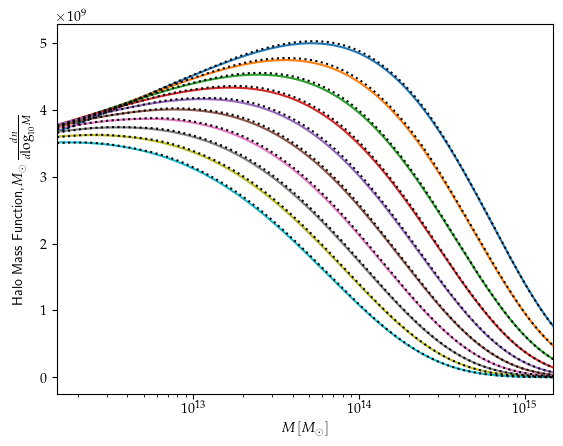

In [12]:
plt.plot(m_arr, m_arr.reshape(-1,1) * record_mf_ccl)
plt.plot(m_arr, m_arr.reshape(-1,1) * record_mf_jax, linestyle = ':', color = 'k')
plt.ylabel(r'Halo Mass Function,' + r'$M_{\odot}\,\frac{dn}{d\textrm{log}_{10}M}$')
plt.xlabel(r'$M\,[M_{\odot}]$')
plt.xlim(min(m_arr), max(m_arr))
plt.xscale('log')
plt.show()

## Halo Bias